# BMO Credit Card Use Case 2 Modelling

Bit of set up to start with...  Let's make sure skflow is installed.

In [112]:
%%bash
pip install skflow

Cleaning up...


Imports...

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gcp
import gcp.bigquery as bq
import skflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

Personal preference but I like to wind these configuration settings up because we work with some wide DataFrames and I like to see all the column headings.  Similar argument for rows.

In [114]:
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

## Use Case 2: Method of Payment of Card Balances

From the use case description document...

* This scenario purports to detect AML risks in which a money launder may be using money from hard-to-trace source to pay off credit card balance.
* Categorize the credit payments by the payment methods and look for unusual patterns, e.g. consistent or large usage of ACH by a domestic customer to pay off the credit card
* The following fields should be part of transaction data schema.

|Transaction Type|Credit_Debit_Flag|
|---|---|
|Payment|C (Credit)|
|Refund|C|
|Reversal|C|
|Award|C|
|Purchase|D (Debit)|
|Fee|D|
|Interest Charge|D|
|Penalty|D|

|Payment Method|
|---|
|Cash|
|Wire|
|ACH|
|Paper Check|
|e-Check|
|Online Transfer|
|Payment at ATM|

What we'll take from this is the simplest possible interpretation...  We'll look at credits made to accounts and see if we can infer fraud from the patterns in those credits.  N.B. We'll ignore all other factors in this first version although we woudn't in later versions.  This one is for illustrative purposes.

## Exploratory Data Analysis (Abbreviated)

First of all, let's get a feel for the data...

We'll pull in the data for Use Case 2 and pivot it to give us a count for each variant of the use case (Green, Yellow, Red) of the number of transactions of each credit action.

In [115]:
%%sql --module use_case_2

DEFINE QUERY trans_by_type
SELECT
  USE_CASE as use_case,
  TRANSACTION_TYPE AS trans_type,
  COUNT(*) AS num_trans
FROM
  [CreditCardv2.cc_trans_02052016]
WHERE
  REGEXP_MATCH(USE_CASE, 'Use Case 2')
  AND CREDIT_DEBIT == 'C'
GROUP BY
  trans_type, use_case
ORDER BY
  trans_type, use_case

In [116]:
trans_by_type = bq.Query(use_case_2.trans_by_type).to_dataframe()

In [117]:
trans_by_type_pivoted = trans_by_type.pivot('trans_type', 'use_case')
trans_by_type_pivoted = trans_by_type_pivoted.fillna(0)
trans_by_type_pivoted

num_trans                   \
use_case                Use Case 2 - Green Use Case 2 - Red   
trans_type                                                    
ACH Payment                        6995617          1126334   
ACH PaymentCash Payment            2332970           376609   
ATM Payment                        2332031           376759   
ATM PaymentPaper Check            13991200                0   
Cash Payment                       2330893           376810   
Online Transfer                   16329172           375450   
Paper Check                        2332869           376196   
Payment                            5789629           353824   
Wire Payment                       4665774           753237   
e-Check Check                     16321869           375418   

                                             
use_case                Use Case 2 - Yellow  
trans_type                                   
ACH Payment                         1290448  
ACH PaymentCash Payment              429694  
ATM Payment                          429245  
ATM PaymentPaper Check               858162  
Cash Payment                         429398  
Online Transfer                     1287583  
Paper Check                          429013  
Payment                              625110  
Wire Payment                         859280  
e-Check Check                       1291977

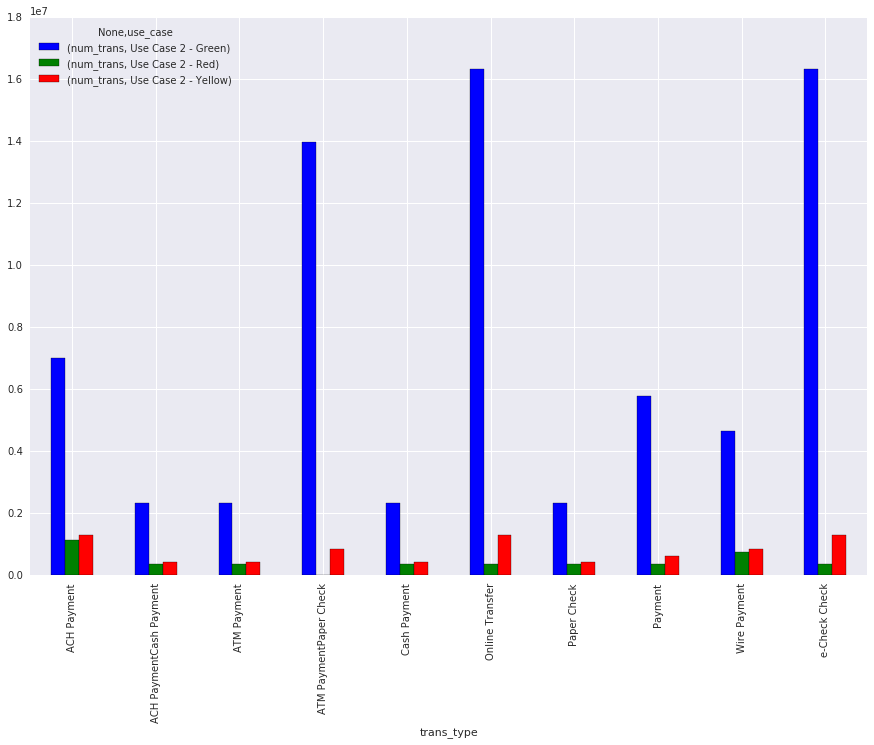

In [118]:
_ = trans_by_type_pivoted.plot(kind='bar', figsize=(15,10))

Which effectively shows us that there are a lot more instances of Green, than Yellow, than Red.  This is physically true but doesn't advance our hypothesis so let's scale the data so everything is a fraction of 1.

In [119]:
trans_by_type_pivoted = trans_by_type_pivoted.divide(trans_by_type_pivoted.sum(), axis=1)
trans_by_type_pivoted

num_trans                   \
use_case                Use Case 2 - Green Use Case 2 - Red   
trans_type                                                    
ACH Payment                       0.095280         0.250818   
ACH PaymentCash Payment           0.031775         0.083865   
ATM Payment                       0.031762         0.083899   
ATM PaymentPaper Check            0.190559         0.000000   
Cash Payment                      0.031747         0.083910   
Online Transfer                   0.222402         0.083607   
Paper Check                       0.031773         0.083773   
Payment                           0.078854         0.078791   
Wire Payment                      0.063547         0.167735   
e-Check Check                     0.222302         0.083600   

                                             
use_case                Use Case 2 - Yellow  
trans_type                                   
ACH Payment                        0.162732  
ACH PaymentCash Payment            0.054186  
ATM Payment                        0.054130  
ATM PaymentPaper Check             0.108218  
Cash Payment                       0.054149  
Online Transfer                    0.162370  
Paper Check                        0.054101  
Payment                            0.078829  
Wire Payment                       0.108359  
e-Check Check                      0.162925

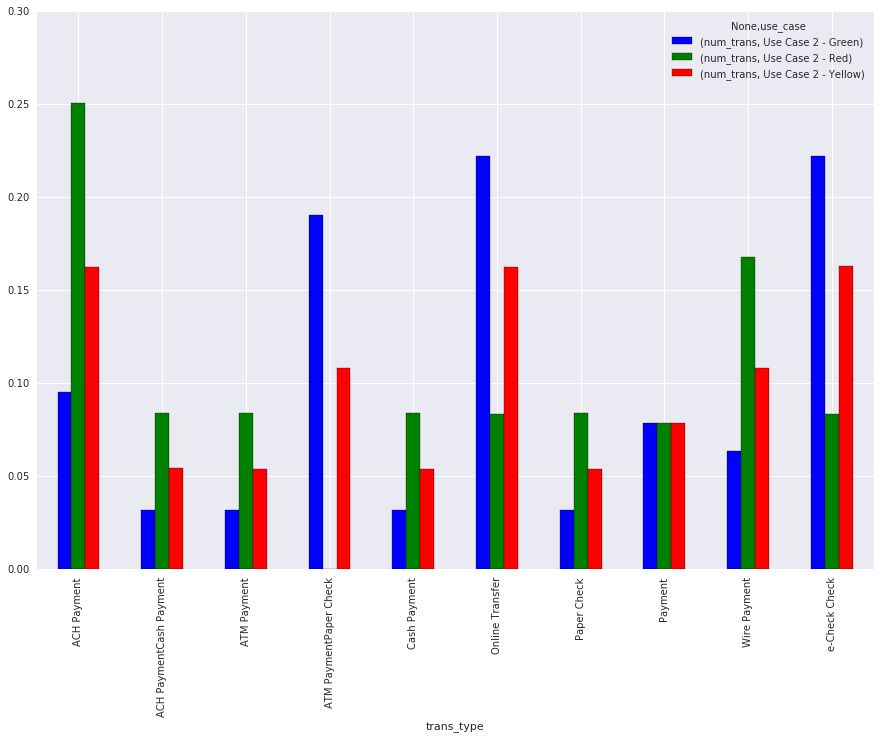

In [120]:
_ = trans_by_type_pivoted.plot(kind='bar', figsize=(15,10))

Now we see some signal in the data, good.

## Model Development

We'll stay with our theme of simplicity.  Our model will be the following:

* Sample the transaction data, take only the credit events, and take equal populations of Green, Yellow and Red.
* For each account in the sampled data and ransform the data from rows in sequential order, to columns in the same order.  I.e.
    
||||
|---|---|---|
|1|ACH|100|
|2|Check|50|
|3|Wire|25|
    
   becomes,
    
||||
|---|---|---|
|ACH|Check|Wire|

* For each row, encode the data one-hot.  I.e. with three options ACH, Check, Wire, each option is encoded as a vector of size 3, e.g.

|||||
|---|---|---|---|
|ACH|0|0|1|
|Check|0|1|0|
|Wire|1|0|0|

So, effectively we'll look at time-ordered sequences of credit actions and see if we can learn patterns from them that indicate fraud.

We'll focus on two things here:

1. The length of the time-ordered sequence.  This is super-important because the aim here is to identify fraud as early as possible.  If our model does a good job of classifying fraud given 5 years of data that's fraud that's occured for 5 years.  If our model does a good job of classifying fraud given 6-12 months of data that's a vast improvement.
1. The type of model - RandomForest versus Feed Forward Neural Net.

N.B. Challenge everything!  This is one approach to this modelling exercise.  It's a signpost in the right direction but should be regarded as incomplete.

In [121]:
%%sql --module use_case_2

DEFINE QUERY sample_trans
SELECT
  *
FROM
  [CreditCardv2.cc_trans_02052016]
WHERE
  USE_CASE = $use_case AND
  CREDIT_DEBIT = 'C'
ORDER BY
  ACCOUNTID, TRANSACTION_DATE
LIMIT
  $sample_size

In [122]:
SAMPLE_SIZE = 100000

GREEN_USE_CASE = 'Use Case 2 - Green'
YELLOW_USE_CASE = 'Use Case 2 - Yellow'
RED_USE_CASE = 'Use Case 2 - Red'

GREEN = 'Green'
YELLOW = 'Yellow'
RED = 'Red'

In [123]:
# This function transforms our DataFrame from a row per transaction to a column per credit event type.
# This introduces some NaN elements so it also transforms those to 'Missing'
# TRANSACTION_DATE is included to allow us to later combine and sort different samples together.

def widen_trans_per_account(sample_trans, use_case, width):
  
  sample_trans_acct_ids = sample_trans.ACCOUNTID.drop_duplicates()

  sample_trans_wide = pd.DataFrame()

  for sample_trans_acct_id in sample_trans_acct_ids:
    sample_trans_acct = sample_trans[sample_trans.ACCOUNTID == sample_trans_acct_id]
    tmp = pd.DataFrame()
    for i in range(width):
      tmp['shift_' + str(i)] = sample_trans_acct.TRANSACTION_TYPE.shift(i)
    sample_trans_wide = pd.concat([sample_trans_wide, tmp])

  sample_trans_wide['USE_CASE'] = use_case
  sample_trans_wide['TRANSACTION_DATE'] = sample_trans.TRANSACTION_DATE
  
  sample_trans_wide = sample_trans_wide.fillna('Missing')
  
  return sample_trans_wide

## Source the Transaction Data

In [124]:
sample_trans_green = bq.Query(use_case_2.sample_trans, use_case = GREEN_USE_CASE, sample_size=SAMPLE_SIZE).to_dataframe()
sample_trans_green[:3]

,ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0,2_2016-02-04 17:45:21,100000039,None,1111,Customer Payment,US,2015-01-06,2015-01-05,e-Check Check,C,20000,101,262,18442345145083904,amex,Use Case 2 - Green,Zilpha Trantow DDS,3,RESEDA,CA,91335,US,None
1,4_2016-02-04 17:45:21,100000039,None,1111,Customer Payment,US,2015-01-10,2015-01-09,e-Check Check,C,20000,1,16,18442345145083904,amex,Use Case 2 - Green,Zilpha Trantow DDS,3,RESEDA,CA,91335,US,None
2,7_2016-02-04 17:45:21,100000039,None,1111,Customer Payment,US,2015-01-16,2015-01-15,e-Check Check,C,20000,1,5,18442345145083904,amex,Use Case 2 - Green,Zilpha Trantow DDS,3,RESEDA,CA,91335,US,None


In [125]:
sample_trans_yellow = bq.Query(use_case_2.sample_trans, use_case = YELLOW_USE_CASE, sample_size=SAMPLE_SIZE).to_dataframe()
sample_trans_yellow[:3]

,ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0,0_2016-02-04 17:45:22,100000846,None,1111,Customer Payment,US,2015-01-02,2015-01-01,Paper Check,C,9000,8942,17942,60452345145471311,visa,Use Case 2 - Yellow,Adrain Wiza,2,BROOKLYN,NY,11214,US,None
1,2_2016-02-04 17:45:22,100000846,None,1111,Customer Payment,US,2015-01-06,2015-01-05,e-Check Check,C,9000,6482,16106,60452345145471311,visa,Use Case 2 - Yellow,Adrain Wiza,2,BROOKLYN,NY,11214,US,None
2,8_2016-02-04 17:45:22,100000846,None,1111,Customer Payment,US,2015-01-22,2015-01-21,e-Check Check,C,9000,2004,4131,60452345145471311,visa,Use Case 2 - Yellow,Adrain Wiza,2,BROOKLYN,NY,11214,US,None


In [126]:
sample_trans_red = bq.Query(use_case_2.sample_trans, use_case=RED_USE_CASE, sample_size=SAMPLE_SIZE).to_dataframe()
sample_trans_red[:3]

,ROWNUM,ACCOUNTID,MERCHANT_NAME,MERCHANT_CATEGORY_CODE,MERCHANT_CATEGORY_DESC,MERCHANT_COUNTRY,POST_DATE,TRANSACTION_DATE,TRANSACTION_TYPE,CREDIT_DEBIT,CREDIT_LIMIT,AMOUNT,BALANCE,CREDITCARDNUMBER,CC_TYPE,USE_CASE,CUST_NAME,NUM_CCS,CUST_CITY,CUST_STATE,CUST_ZIP,CUST_COUNTRY,TRANS_DETAIL
0,1_2016-02-04 17:45:26,100005488,None,1111,Customer Payment,US,2015-01-07,2015-01-06,Paper Check,C,17000,9038,24922,99922345147746593,amex,Use Case 2 - Red,Rick Herman,1,DALLAS,TX,75228,US,None
1,9_2016-02-04 17:45:26,100005488,None,1111,Customer Payment,US,2015-01-19,2015-01-18,Online Transfer,C,17000,174,666,99922345147746593,amex,Use Case 2 - Red,Rick Herman,1,DALLAS,TX,75228,US,None
2,10_2016-02-04 17:45:26,100005488,None,1111,Customer Payment,US,2015-01-20,2015-01-19,ATM Payment,C,17000,215,881,99922345147746593,amex,Use Case 2 - Red,Rick Herman,1,DALLAS,TX,75228,US,None


## Transform the Data to Time-Ordered Sequences and Rock and Roll V1

In [127]:
WIDTH = 12 # Look at the last 12 payments...

In [128]:
sample_trans_green_wide = widen_trans_per_account(sample_trans_green, GREEN, WIDTH)

print sample_trans_green_wide.shape
print
print sample_trans_green_wide.describe()
print
sample_trans_green_wide[:3]

(100000, 14)

              shift_0        shift_1        shift_2        shift_3  \
count          100000         100000         100000         100000   
unique             10             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            22351          22328          21957          21590   

              shift_4        shift_5        shift_6        shift_7  \
count          100000         100000         100000         100000   
unique             11             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            21219          20845          20485          20135   

              shift_8        shift_9       shift_10       shift_11 USE_CASE  \
count          100000         100000         100000         100000   100000   
unique             11             11             11             11        1   
top     e-Check Check  e-Check Check  e-Check C

,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,USE_CASE,TRANSACTION_DATE
0,e-Check Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Green,2015-01-05
1,e-Check Check,e-Check Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Green,2015-01-09
2,e-Check Check,e-Check Check,e-Check Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Green,2015-01-15


In [129]:
sample_trans_yellow_wide = widen_trans_per_account(sample_trans_yellow, YELLOW, WIDTH)

print sample_trans_yellow_wide.shape
print
print sample_trans_yellow_wide.describe()
print
sample_trans_yellow_wide[:3]

(100000, 14)

            shift_0      shift_1      shift_2      shift_3      shift_4  \
count        100000       100000       100000       100000       100000   
unique           10           11           11           11           11   
top     ACH Payment  ACH Payment  ACH Payment  ACH Payment  ACH Payment   
freq          16450        16435        16160        15871        15629   

            shift_5      shift_6      shift_7      shift_8  shift_9 shift_10  \
count        100000       100000       100000       100000   100000   100000   
unique           11           11           11           11       11       11   
top     ACH Payment  ACH Payment  ACH Payment  ACH Payment  Missing  Missing   
freq          15335        15058        14820        14544    14508    16120   

       shift_11 USE_CASE TRANSACTION_DATE  
count    100000   100000           100000  
unique       11        1              321  
top     Missing   Yellow       2015-06-10  
freq      17732   100000         

,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,USE_CASE,TRANSACTION_DATE
0,Paper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Yellow,2015-01-01
1,e-Check Check,Paper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Yellow,2015-01-05
2,e-Check Check,e-Check Check,Paper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Yellow,2015-01-21


In [130]:
sample_trans_red_wide = widen_trans_per_account(sample_trans_red, RED, WIDTH)

print sample_trans_red_wide.shape
print
print sample_trans_red_wide.describe()
print
sample_trans_red_wide[:3]

(100000, 14)

            shift_0      shift_1      shift_2      shift_3      shift_4  \
count        100000       100000       100000       100000       100000   
unique            9           10           10           10           10   
top     ACH Payment  ACH Payment  ACH Payment  ACH Payment  ACH Payment   
freq          25325        25304        24890        24481        24073   

            shift_5      shift_6      shift_7      shift_8      shift_9  \
count        100000       100000       100000       100000       100000   
unique           10           10           10           10           10   
top     ACH Payment  ACH Payment  ACH Payment  ACH Payment  ACH Payment   
freq          23679        23271        22834        22430        22039   

           shift_10     shift_11 USE_CASE TRANSACTION_DATE  
count        100000       100000   100000           100000  
unique           10           10        1              323  
top     ACH Payment  ACH Payment      Red       201

,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,USE_CASE,TRANSACTION_DATE
0,Paper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Red,2015-01-06
1,Online Transfer,Paper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Red,2015-01-18
2,ATM Payment,Online Transfer,Paper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Red,2015-01-19


In [131]:
sample_trans_wide = pd.concat([sample_trans_green_wide, sample_trans_yellow_wide, sample_trans_red_wide])
sample_trans_wide = sample_trans_wide.sort_values('TRANSACTION_DATE')
sample_trans_wide = sample_trans_wide.drop('TRANSACTION_DATE', 1)

print sample_trans_wide.describe()
print
sample_trans_wide[:3]

            shift_0      shift_1      shift_2      shift_3      shift_4  \
count        300000       300000       300000       300000       300000   
unique           10           11           11           11           11   
top     ACH Payment  ACH Payment  ACH Payment  ACH Payment  ACH Payment   
freq          51347        51302        50466        49602        48803   

            shift_5      shift_6      shift_7      shift_8      shift_9  \
count        300000       300000       300000       300000       300000   
unique           11           11           11           11           11   
top     ACH Payment  ACH Payment  ACH Payment  ACH Payment  ACH Payment   
freq          47974        47114        46288        45433        44598   

       shift_10 shift_11 USE_CASE  
count    300000   300000   300000  
unique       11       11        3  
top     Missing  Missing      Red  
freq      48530    53382   100000  



,shift_0,shift_1,shift_2,shift_3,shift_4,shift_5,shift_6,shift_7,shift_8,shift_9,shift_10,shift_11,USE_CASE
93990,ATM PaymentPaper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Yellow
21746,ATM PaymentPaper Check,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Green
99922,ATM Payment,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Missing,Green


In [132]:
shift_encoder = preprocessing.LabelEncoder()
shift_encoder.fit(sample_trans_wide.shift_1.drop_duplicates())

use_case_encoder = preprocessing.LabelEncoder()
use_case_encoder.fit(sample_trans_wide.USE_CASE.drop_duplicates())

sample_trans_wide_enc = pd.DataFrame(index=sample_trans_wide.index)

sample_trans_wide_enc['USE_CASE'] = use_case_encoder.transform(sample_trans_wide.USE_CASE)

for i in range(WIDTH):
  sample_trans_wide_enc['shift_' + str(i) + '_enc'] = shift_encoder.transform(sample_trans_wide['shift_' + str(i)])

sample_trans_wide_enc[:5]

,USE_CASE,shift_0_enc,shift_1_enc,shift_2_enc,shift_3_enc,shift_4_enc,shift_5_enc,shift_6_enc,shift_7_enc,shift_8_enc,shift_9_enc,shift_10_enc,shift_11_enc
93990,2,3,5,5,5,5,5,5,5,5,5,5,5
21746,0,3,5,5,5,5,5,5,5,5,5,5,5
99922,0,2,5,5,5,5,5,5,5,5,5,5,5
99864,0,6,5,5,5,5,5,5,5,5,5,5,5
70547,0,6,5,5,5,5,5,5,5,5,5,5,5


In [133]:
X = sample_trans_wide_enc[sample_trans_wide_enc.columns[1:]]
X[:5]

,shift_0_enc,shift_1_enc,shift_2_enc,shift_3_enc,shift_4_enc,shift_5_enc,shift_6_enc,shift_7_enc,shift_8_enc,shift_9_enc,shift_10_enc,shift_11_enc
93990,3,5,5,5,5,5,5,5,5,5,5,5
21746,3,5,5,5,5,5,5,5,5,5,5,5
99922,2,5,5,5,5,5,5,5,5,5,5,5
99864,6,5,5,5,5,5,5,5,5,5,5,5
70547,6,5,5,5,5,5,5,5,5,5,5,5


In [134]:
y = sample_trans_wide_enc[sample_trans_wide_enc.columns[0]]
y[:5]

93990    2
21746    0
99922    0
99864    0
70547    0
Name: USE_CASE, dtype: int64

In [135]:
X_enc = pd.DataFrame()
for i in range(WIDTH):
  enc = preprocessing.OneHotEncoder()
  enc.fit(X['shift_' + str(i) + '_enc'].values.reshape((-1,1)))
  X_enc = pd.concat([X_enc, pd.DataFrame(enc.transform(X['shift_' + str(i) + '_enc'].values.reshape((-1,1))).toarray())], axis=1)

X_enc.columns = [i for i in range(len(X_enc.columns))]
X_enc[:5]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [136]:
X_split = int(len(X_enc) * 0.8)
X_train = X_enc[:X_split]
X_test = X_enc[X_split:]

y_split = int(len(y) * 0.8)
y_train = y[:y_split]
y_test = y[y_split:]

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(240000, 131) (60000, 131) (240000,) (60000,)


In [137]:
classifier = RandomForestClassifier(n_estimators = 25)
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

0.969683333333
0.751383333333

             precision    recall  f1-score   support

          0       0.72      0.77      0.74     20071
          1       0.83      0.97      0.89     19598
          2       0.68      0.53      0.60     20331

avg / total       0.74      0.75      0.74     60000


[[15364   327  4380]
 [   32 18944   622]
 [ 6047  3509 10775]]


In [138]:
def model(X, y):
  layers = skflow.ops.dnn(X, [25], keep_prob=0.5)
  return skflow.models.logistic_regression(layers, y)

classifier = skflow.TensorFlowEstimator(
  model_fn=model, n_classes=3, steps=10000, learning_rate=0.003, optimizer='Adam')
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

Step #1, avg. loss: 1.46243
Step #1001, avg. loss: 0.63945
Step #2001, avg. loss: 0.55404
Step #3001, avg. loss: 0.54974
Step #4001, avg. loss: 0.54750
Step #5001, avg. loss: 0.54136
Step #6001, avg. loss: 0.54247
Step #7001, avg. loss: 0.53807
Step #8001, epoch #1, avg. loss: 0.53667
Step #9001, epoch #1, avg. loss: 0.53821
0.762925
0.780766666667

             precision    recall  f1-score   support

          0       0.73      0.84      0.78     20071
          1       0.86      0.96      0.91     19598
          2       0.75      0.54      0.63     20331

avg / total       0.78      0.78      0.77     60000


[[16947   164  2960]
 [   13 18834   751]
 [ 6332  2934 11065]]


## Transform the Data to Time-Ordered Sequences and Rock and Roll V2

In [139]:
WIDTH = 24 # Look at the last 24 payments...

sample_trans_green_wide = widen_trans_per_account(sample_trans_green, GREEN, WIDTH)

print sample_trans_green_wide.shape
print
print sample_trans_green_wide.describe()
print
print sample_trans_green_wide[:3]
print

sample_trans_yellow_wide = widen_trans_per_account(sample_trans_yellow, YELLOW, WIDTH)

print sample_trans_yellow_wide.shape
print
print sample_trans_yellow_wide.describe()
print
print sample_trans_yellow_wide[:3]
print

sample_trans_red_wide = widen_trans_per_account(sample_trans_red, RED, WIDTH)

print sample_trans_red_wide.shape
print
print sample_trans_red_wide.describe()
print
print sample_trans_red_wide[:3]
print

sample_trans_wide = pd.concat([sample_trans_green_wide, sample_trans_yellow_wide, sample_trans_red_wide])
sample_trans_wide = sample_trans_wide.sort_values('TRANSACTION_DATE')
sample_trans_wide = sample_trans_wide.drop('TRANSACTION_DATE', 1)

print sample_trans_wide.describe()
print
print sample_trans_wide[:3]
print

shift_encoder = preprocessing.LabelEncoder()
shift_encoder.fit(sample_trans_wide.shift_1.drop_duplicates())

use_case_encoder = preprocessing.LabelEncoder()
use_case_encoder.fit(sample_trans_wide.USE_CASE.drop_duplicates())

sample_trans_wide_enc = pd.DataFrame(index=sample_trans_wide.index)

sample_trans_wide_enc['USE_CASE'] = use_case_encoder.transform(sample_trans_wide.USE_CASE)

for i in range(WIDTH):
  sample_trans_wide_enc['shift_' + str(i) + '_enc'] = shift_encoder.transform(sample_trans_wide['shift_' + str(i)])

print sample_trans_wide_enc[:5]
print 

X = sample_trans_wide_enc[sample_trans_wide_enc.columns[1:]]
print X[:5]
print 

y = sample_trans_wide_enc[sample_trans_wide_enc.columns[0]]
print y[:5]
print

X_enc = pd.DataFrame()
for i in range(WIDTH):
  enc = preprocessing.OneHotEncoder()
  enc.fit(X['shift_' + str(i) + '_enc'].values.reshape((-1,1)))
  X_enc = pd.concat([X_enc, pd.DataFrame(enc.transform(X['shift_' + str(i) + '_enc'].values.reshape((-1,1))).toarray())], axis=1)

X_enc.columns = [i for i in range(len(X_enc.columns))]
print X_enc[:5]
print

X_split = int(len(X_enc) * 0.8)
X_train = X_enc[:X_split]
X_test = X_enc[X_split:]

y_split = int(len(y) * 0.8)
y_train = y[:y_split]
y_test = y[y_split:]

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(100000, 26)

              shift_0        shift_1        shift_2        shift_3  \
count          100000         100000         100000         100000   
unique             10             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            22351          22328          21957          21590   

              shift_4        shift_5        shift_6        shift_7  \
count          100000         100000         100000         100000   
unique             11             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            21219          20845          20485          20135   

              shift_8        shift_9       shift_10       shift_11 shift_12  \
count          100000         100000         100000         100000   100000   
unique             11             11             11             11       11   
top     e-Check Check  e-Check Check  e-Check C

In [140]:
classifier = RandomForestClassifier(n_estimators = 50)
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

0.970441666667
0.84075

             precision    recall  f1-score   support

          0       0.78      0.83      0.80     20071
          1       0.93      1.00      0.96     19598
          2       0.81      0.69      0.75     20331

avg / total       0.84      0.84      0.84     60000


[[16742    84  3245]
 [    0 19597     1]
 [ 4838  1387 14106]]


In [141]:
def model(X, y):
  layers = skflow.ops.dnn(X, [50], keep_prob=0.5)
  return skflow.models.logistic_regression(layers, y)

classifier = skflow.TensorFlowEstimator(
  model_fn=model, n_classes=3, steps=10000, learning_rate=0.003, optimizer='Adam')
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

Step #1, avg. loss: 1.40088
Step #1001, avg. loss: 0.49627
Step #2001, avg. loss: 0.42734
Step #3001, avg. loss: 0.42292
Step #4001, avg. loss: 0.42280
Step #5001, avg. loss: 0.41674
Step #6001, avg. loss: 0.40868
Step #7001, avg. loss: 0.40914
Step #8001, epoch #1, avg. loss: 0.40493
Step #9001, epoch #1, avg. loss: 0.40455
0.8265375
0.878183333333

             precision    recall  f1-score   support

          0       0.80      0.91      0.85     20071
          1       0.95      0.99      0.97     19598
          2       0.89      0.73      0.80     20331

avg / total       0.88      0.88      0.88     60000


[[18285     3  1783]
 [    0 19473   125]
 [ 4468   930 14933]]


## Transform the Data to Time-Ordered Sequences and Rock and Roll V3

In [142]:
WIDTH = 60 # Look at the last 60 payments...

sample_trans_green_wide = widen_trans_per_account(sample_trans_green, GREEN, WIDTH)

print sample_trans_green_wide.shape
print
print sample_trans_green_wide.describe()
print
print sample_trans_green_wide[:3]
print

sample_trans_yellow_wide = widen_trans_per_account(sample_trans_yellow, YELLOW, WIDTH)

print sample_trans_yellow_wide.shape
print
print sample_trans_yellow_wide.describe()
print
print sample_trans_yellow_wide[:3]
print

sample_trans_red_wide = widen_trans_per_account(sample_trans_red, RED, WIDTH)

print sample_trans_red_wide.shape
print
print sample_trans_red_wide.describe()
print
print sample_trans_red_wide[:3]
print

sample_trans_wide = pd.concat([sample_trans_green_wide, sample_trans_yellow_wide, sample_trans_red_wide])
sample_trans_wide = sample_trans_wide.sort_values('TRANSACTION_DATE')
sample_trans_wide = sample_trans_wide.drop('TRANSACTION_DATE', 1)

print sample_trans_wide.describe()
print
print sample_trans_wide[:3]
print

shift_encoder = preprocessing.LabelEncoder()
shift_encoder.fit(sample_trans_wide.shift_1.drop_duplicates())

use_case_encoder = preprocessing.LabelEncoder()
use_case_encoder.fit(sample_trans_wide.USE_CASE.drop_duplicates())

sample_trans_wide_enc = pd.DataFrame(index=sample_trans_wide.index)

sample_trans_wide_enc['USE_CASE'] = use_case_encoder.transform(sample_trans_wide.USE_CASE)

for i in range(WIDTH):
  sample_trans_wide_enc['shift_' + str(i) + '_enc'] = shift_encoder.transform(sample_trans_wide['shift_' + str(i)])

print sample_trans_wide_enc[:5]
print 

X = sample_trans_wide_enc[sample_trans_wide_enc.columns[1:]]
print X[:5]
print 

y = sample_trans_wide_enc[sample_trans_wide_enc.columns[0]]
print y[:5]
print

X_enc = pd.DataFrame()
for i in range(WIDTH):
  enc = preprocessing.OneHotEncoder()
  enc.fit(X['shift_' + str(i) + '_enc'].values.reshape((-1,1)))
  X_enc = pd.concat([X_enc, pd.DataFrame(enc.transform(X['shift_' + str(i) + '_enc'].values.reshape((-1,1))).toarray())], axis=1)

X_enc.columns = [i for i in range(len(X_enc.columns))]
print X_enc[:5]
print

X_split = int(len(X_enc) * 0.8)
X_train = X_enc[:X_split]
X_test = X_enc[X_split:]

y_split = int(len(y) * 0.8)
y_train = y[:y_split]
y_test = y[y_split:]

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(100000, 62)

              shift_0        shift_1        shift_2        shift_3  \
count          100000         100000         100000         100000   
unique             10             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            22351          22328          21957          21590   

              shift_4        shift_5        shift_6        shift_7  \
count          100000         100000         100000         100000   
unique             11             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            21219          20845          20485          20135   

              shift_8        shift_9       shift_10       shift_11 shift_12  \
count          100000         100000         100000         100000   100000   
unique             11             11             11             11       11   
top     e-Check Check  e-Check Check  e-Check C

In [143]:
classifier = RandomForestClassifier(n_estimators = 250)
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

0.970495833333
0.907333333333

             precision    recall  f1-score   support

          0       0.85      0.89      0.87     20071
          1       0.98      1.00      0.99     19598
          2       0.89      0.83      0.86     20331

avg / total       0.91      0.91      0.91     60000


[[17947     4  2120]
 [    0 19598     0]
 [ 3093   343 16895]]


In [144]:
def model(X, y):
  layers = skflow.ops.dnn(X, [400], keep_prob=0.5)
  return skflow.models.logistic_regression(layers, y)

classifier = skflow.TensorFlowEstimator(
  model_fn=model, n_classes=3, steps=10000, learning_rate=0.003, optimizer='Adam')
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

Step #1, avg. loss: 1.52429
Step #1001, avg. loss: 0.43904
Step #2001, avg. loss: 0.39523
Step #3001, avg. loss: 0.39195
Step #4001, avg. loss: 0.38848
Step #5001, avg. loss: 0.38466
Step #6001, avg. loss: 0.37750
Step #7001, avg. loss: 0.37531
Step #8001, epoch #1, avg. loss: 0.36547
Step #9001, epoch #1, avg. loss: 0.36620
0.8430125
0.946683333333

             precision    recall  f1-score   support

          0       0.93      0.94      0.93     20071
          1       0.97      1.00      0.99     19598
          2       0.93      0.91      0.92     20331

avg / total       0.95      0.95      0.95     60000


[[18797     0  1274]
 [    0 19592     6]
 [ 1346   573 18412]]


## Transform the Data to Time-Ordered Sequences and Rock and Roll V4

In [145]:
WIDTH = 100 # Look at the last 100 payments...

sample_trans_green_wide = widen_trans_per_account(sample_trans_green, GREEN, WIDTH)

print sample_trans_green_wide.shape
print
print sample_trans_green_wide.describe()
print
print sample_trans_green_wide[:3]
print

sample_trans_yellow_wide = widen_trans_per_account(sample_trans_yellow, YELLOW, WIDTH)

print sample_trans_yellow_wide.shape
print
print sample_trans_yellow_wide.describe()
print
print sample_trans_yellow_wide[:3]
print

sample_trans_red_wide = widen_trans_per_account(sample_trans_red, RED, WIDTH)

print sample_trans_red_wide.shape
print
print sample_trans_red_wide.describe()
print
print sample_trans_red_wide[:3]
print

sample_trans_wide = pd.concat([sample_trans_green_wide, sample_trans_yellow_wide, sample_trans_red_wide])
sample_trans_wide = sample_trans_wide.sort_values('TRANSACTION_DATE')
sample_trans_wide = sample_trans_wide.drop('TRANSACTION_DATE', 1)

print sample_trans_wide.describe()
print
print sample_trans_wide[:3]
print

shift_encoder = preprocessing.LabelEncoder()
shift_encoder.fit(sample_trans_wide.shift_1.drop_duplicates())

use_case_encoder = preprocessing.LabelEncoder()
use_case_encoder.fit(sample_trans_wide.USE_CASE.drop_duplicates())

sample_trans_wide_enc = pd.DataFrame(index=sample_trans_wide.index)

sample_trans_wide_enc['USE_CASE'] = use_case_encoder.transform(sample_trans_wide.USE_CASE)

for i in range(WIDTH):
  sample_trans_wide_enc['shift_' + str(i) + '_enc'] = shift_encoder.transform(sample_trans_wide['shift_' + str(i)])

print sample_trans_wide_enc[:5]
print 

X = sample_trans_wide_enc[sample_trans_wide_enc.columns[1:]]
print X[:5]
print 

y = sample_trans_wide_enc[sample_trans_wide_enc.columns[0]]
print y[:5]
print

X_enc = pd.DataFrame()
for i in range(WIDTH):
  enc = preprocessing.OneHotEncoder()
  enc.fit(X['shift_' + str(i) + '_enc'].values.reshape((-1,1)))
  X_enc = pd.concat([X_enc, pd.DataFrame(enc.transform(X['shift_' + str(i) + '_enc'].values.reshape((-1,1))).toarray())], axis=1)

X_enc.columns = [i for i in range(len(X_enc.columns))]
print X_enc[:5]
print

X_split = int(len(X_enc) * 0.8)
X_train = X_enc[:X_split]
X_test = X_enc[X_split:]

y_split = int(len(y) * 0.8)
y_train = y[:y_split]
y_test = y[y_split:]

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(100000, 102)

              shift_0        shift_1        shift_2        shift_3  \
count          100000         100000         100000         100000   
unique             10             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            22351          22328          21957          21590   

              shift_4        shift_5        shift_6        shift_7  \
count          100000         100000         100000         100000   
unique             11             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            21219          20845          20485          20135   

              shift_8        shift_9       shift_10       shift_11 shift_12  \
count          100000         100000         100000         100000   100000   
unique             11             11             11             11       11   
top     e-Check Check  e-Check Check  e-Check 

In [146]:
classifier = RandomForestClassifier(n_estimators = 250)
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

0.970495833333
0.906883333333

             precision    recall  f1-score   support

          0       0.85      0.90      0.87     20071
          1       0.98      1.00      0.99     19598
          2       0.89      0.83      0.86     20331

avg / total       0.91      0.91      0.91     60000


[[18026     6  2039]
 [    0 19598     0]
 [ 3143   399 16789]]


In [147]:
def model(X, y):
  layers = skflow.ops.dnn(X, [1600], keep_prob=0.5)
  return skflow.models.logistic_regression(layers, y)

classifier = skflow.TensorFlowEstimator(
  model_fn=model, n_classes=3, steps=10000, learning_rate=0.003, optimizer='Adam')
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

Step #1, avg. loss: 1.52460
Step #1001, avg. loss: 0.46792
Step #2001, avg. loss: 0.41031
Step #3001, avg. loss: 0.40136
Step #4001, avg. loss: 0.39769
Step #5001, avg. loss: 0.39711
Step #6001, avg. loss: 0.38669
Step #7001, avg. loss: 0.38448
Step #8001, epoch #1, avg. loss: 0.37591
Step #9001, epoch #1, avg. loss: 0.37654
0.837316666667
0.949633333333

             precision    recall  f1-score   support

          0       0.92      0.96      0.94     20071
          1       0.98      1.00      0.99     19598
          2       0.95      0.90      0.92     20331

avg / total       0.95      0.95      0.95     60000


[[19182     0   889]
 [    0 19596     2]
 [ 1686   445 18200]]


## Transform the Data to Time-Ordered Sequences and Rock and Roll V5

In [148]:
WIDTH = 6 # Look at the last 6 payments...

sample_trans_green_wide = widen_trans_per_account(sample_trans_green, GREEN, WIDTH)

print sample_trans_green_wide.shape
print
print sample_trans_green_wide.describe()
print
print sample_trans_green_wide[:3]
print

sample_trans_yellow_wide = widen_trans_per_account(sample_trans_yellow, YELLOW, WIDTH)

print sample_trans_yellow_wide.shape
print
print sample_trans_yellow_wide.describe()
print
print sample_trans_yellow_wide[:3]
print

sample_trans_red_wide = widen_trans_per_account(sample_trans_red, RED, WIDTH)

print sample_trans_red_wide.shape
print
print sample_trans_red_wide.describe()
print
print sample_trans_red_wide[:3]
print

sample_trans_wide = pd.concat([sample_trans_green_wide, sample_trans_yellow_wide, sample_trans_red_wide])
sample_trans_wide = sample_trans_wide.sort_values('TRANSACTION_DATE')
sample_trans_wide = sample_trans_wide.drop('TRANSACTION_DATE', 1)

print sample_trans_wide.describe()
print
print sample_trans_wide[:3]
print

shift_encoder = preprocessing.LabelEncoder()
shift_encoder.fit(sample_trans_wide.shift_1.drop_duplicates())

use_case_encoder = preprocessing.LabelEncoder()
use_case_encoder.fit(sample_trans_wide.USE_CASE.drop_duplicates())

sample_trans_wide_enc = pd.DataFrame(index=sample_trans_wide.index)

sample_trans_wide_enc['USE_CASE'] = use_case_encoder.transform(sample_trans_wide.USE_CASE)

for i in range(WIDTH):
  sample_trans_wide_enc['shift_' + str(i) + '_enc'] = shift_encoder.transform(sample_trans_wide['shift_' + str(i)])

print sample_trans_wide_enc[:5]
print 

X = sample_trans_wide_enc[sample_trans_wide_enc.columns[1:]]
print X[:5]
print 

y = sample_trans_wide_enc[sample_trans_wide_enc.columns[0]]
print y[:5]
print

X_enc = pd.DataFrame()
for i in range(WIDTH):
  enc = preprocessing.OneHotEncoder()
  enc.fit(X['shift_' + str(i) + '_enc'].values.reshape((-1,1)))
  X_enc = pd.concat([X_enc, pd.DataFrame(enc.transform(X['shift_' + str(i) + '_enc'].values.reshape((-1,1))).toarray())], axis=1)

X_enc.columns = [i for i in range(len(X_enc.columns))]
print X_enc[:5]
print

X_split = int(len(X_enc) * 0.8)
X_train = X_enc[:X_split]
X_test = X_enc[X_split:]

y_split = int(len(y) * 0.8)
y_train = y[:y_split]
y_test = y[y_split:]

print X_train.shape, X_test.shape, y_train.shape, y_test.shape

(100000, 8)

              shift_0        shift_1        shift_2        shift_3  \
count          100000         100000         100000         100000   
unique             10             11             11             11   
top     e-Check Check  e-Check Check  e-Check Check  e-Check Check   
freq            22351          22328          21957          21590   

              shift_4        shift_5 USE_CASE TRANSACTION_DATE  
count          100000         100000   100000           100000  
unique             11             11        1              319  
top     e-Check Check  e-Check Check    Green       2015-04-13  
freq            21219          20845   100000              452  

         shift_0        shift_1        shift_2  shift_3  shift_4  shift_5  \
0  e-Check Check        Missing        Missing  Missing  Missing  Missing   
1  e-Check Check  e-Check Check        Missing  Missing  Missing  Missing   
2  e-Check Check  e-Check Check  e-Check Check  Missing  Missing  Missing   

 

In [149]:
classifier = RandomForestClassifier(n_estimators = 250)
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

0.889483333333
0.632016666667

             precision    recall  f1-score   support

          0       0.64      0.65      0.65     20071
          1       0.72      0.83      0.77     19598
          2       0.50      0.42      0.46     20331

avg / total       0.62      0.63      0.62     60000


[[13130  1243  5698]
 [  600 16206  2792]
 [ 6630  5116  8585]]


In [150]:
def model(X, y):
  layers = skflow.ops.dnn(X, [50], keep_prob=0.5)
  return skflow.models.logistic_regression(layers, y)

classifier = skflow.TensorFlowEstimator(
  model_fn=model, n_classes=3, steps=10000, learning_rate=0.003, optimizer='Adam')
classifier.fit(X_train, y_train)

print accuracy_score(y_train, classifier.predict(X_train))
print accuracy_score(y_test, classifier.predict(X_test))
print

y_pred = classifier.predict(X_test)
print metrics.classification_report(y_test, y_pred)
print
print metrics.confusion_matrix(y_test, y_pred)

Step #1, avg. loss: 1.47250
Step #1001, avg. loss: 0.75359
Step #2001, avg. loss: 0.70379
Step #3001, avg. loss: 0.69963
Step #4001, avg. loss: 0.69896
Step #5001, avg. loss: 0.69798
Step #6001, avg. loss: 0.69236
Step #7001, avg. loss: 0.69939
Step #8001, epoch #1, avg. loss: 0.68874
Step #9001, epoch #1, avg. loss: 0.69323
0.6757
0.674133333333

             precision    recall  f1-score   support

          0       0.67      0.75      0.71     20071
          1       0.72      0.91      0.80     19598
          2       0.58      0.37      0.45     20331

avg / total       0.66      0.67      0.65     60000


[[15088  1149  3834]
 [  268 17798  1532]
 [ 7075  5694  7562]]
